In [1]:
from IPython import get_ipython
get_ipython().magic('reset -sf') 

In [2]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
import seaborn as sns
import matplotlib.ticker as ticker
from statannot import add_stat_annotation

Step 1. Import data from excel-file

In [3]:
def file_extraction(search_string, set): 
    filepaths = glob.glob(search_string) 
    df = pd.DataFrame()
    col_name_suffix = 1
    for find_files in filepaths:
        if set == 'ctrl':
            df = df.join (pd.read_excel(find_files, sheet_name='CTRL'), how='outer',lsuffix=col_name_suffix)
            col_name_suffix +=1
        else: 
            df = df.join (pd.read_excel(find_files, sheet_name='SE'), how='outer',lsuffix=col_name_suffix)
            col_name_suffix +=1
    return(df)

In [4]:
cell_count_CTRL= file_extraction('**/neuro*.xlsx', set = 'ctrl')
cell_count_SE = file_extraction('**/neuro*.xlsx', set = 'SE')
all_cell_count = pd.concat([cell_count_CTRL, cell_count_SE], ignore_index= True)
all_cell_count.rename(columns={'Hilus': 'Хилус', 'DG': 'Зубчатая фасция'}, inplace=True)

In [5]:
all_cell_count.head()

,CA1,CA3,Хилус,Зубчатая фасция,Group
0,15.50802,9.30233,15.555560,26.206900,Контроль
1,15.06024,10.25400,12.426040,29.824560,Контроль
2,15.28413,17.35400,12.903230,22.314050,Контроль
3,10.44776,11.24530,12.664635,24.444440,Контроль
4,13.19444,15.62500,17.015600,25.697488,Контроль


Step 2. Transforming the df to apply hue grouping

In [6]:
all_cell_count = pd.melt (all_cell_count, id_vars= ['Group'], value_vars=['CA1', 'CA3', 'Хилус', 'Зубчатая фасция'],var_name= 'Зона гиппокампа', value_name= 'Количество клеток на 100мкм')
all_cell_count.head()

,Group,Зона гиппокампа,Количество клеток на 100мкм
0,Контроль,CA1,15.50802
1,Контроль,CA1,15.06024
2,Контроль,CA1,15.28413
3,Контроль,CA1,10.44776
4,Контроль,CA1,13.19444


In [7]:
def adjust_box_widths(g, fac): # from https://stackoverflow.com/questions/56838187/how-to-create-spacing-between-same-subgroup-in-seaborn-boxplot
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

Step 3. Create boxplot and calculate statistics

In [8]:
def boxplot_graph(data, dots, fig_name, big_tick, ylim): 
    fig_name = 'figs/cell count/' + fig_name + '.tif'
    fig = plt.figure(figsize=(15,10)) # меняет размер графика
    custom_params = {"axes.spines.right": False, "axes.spines.top": False}
    sns.set_theme(font_scale=1.2, style="ticks",context="poster", rc= custom_params)
    plot = sns.boxplot(data = all_cell_count, x = 'Зона гиппокампа', y = 'Количество клеток на 100мкм', hue = 'Group', 
                                            palette="vlag", linewidth = 5, dodge=True)
    
    plot.spines['left'].set_linewidth(4)
    plot.spines['bottom'].set_linewidth(4)
    plot.yaxis.set_major_locator(ticker.MultipleLocator(big_tick))
    plt.ylim(ylim)
    box_pairs = [(('CA1', 'Контроль'),( 'CA1', 'ЭС')),
                                (('CA3', 'Контроль'),('CA3', 'ЭС')),
                                (('Хилус', 'Контроль'),('Хилус', 'ЭС')),
                                (('Зубчатая фасция', 'Контроль'),( 'Зубчатая фасция', 'ЭС'))]
    ax, stat = add_stat_annotation(plot, data=data,x = 'Зона гиппокампа', y = 'Количество клеток на 100мкм', hue = 'Group',
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star',  verbose=1, comparisons_correction=None, linewidth=3) #loc = 'outside'
    if dots == True:
        sns.swarmplot(x = 'Зона гиппокампа', y = 'Количество клеток на 100мкм', hue = 'Group', data=all_cell_count, 
                                            size = 9, palette = "Set2", linewidth=3 ,dodge = True)
    handles, labels = plot.get_legend_handles_labels()
    plt.legend(handles[0:2], labels[0:2], loc=2, bbox_to_anchor=(1.03, 1), borderaxespad=0)
    adjust_box_widths(fig, 0.9)
    plot = plot.get_figure()
    plt.tight_layout()                                         
    plot.savefig(fig_name, dpi=800)
    return stat

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CA3_Контроль v.s. CA3_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=1.207e-06 U_stat=4.270e+02
CA1_Контроль v.s. CA1_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=3.730e-04 U_stat=3.740e+02
Хилус_Контроль v.s. Хилус_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=8.306e-07 U_stat=4.300e+02
Зубчатая фасция_Контроль v.s. Зубчатая фасция_ЭС: Mann-Whitney-Wilcoxon test two-sided, P_val=1.992e-01 U_stat=2.810e+02


C:\Users\nosov\AppData\Local\Temp/ipykernel_11108/888465776.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


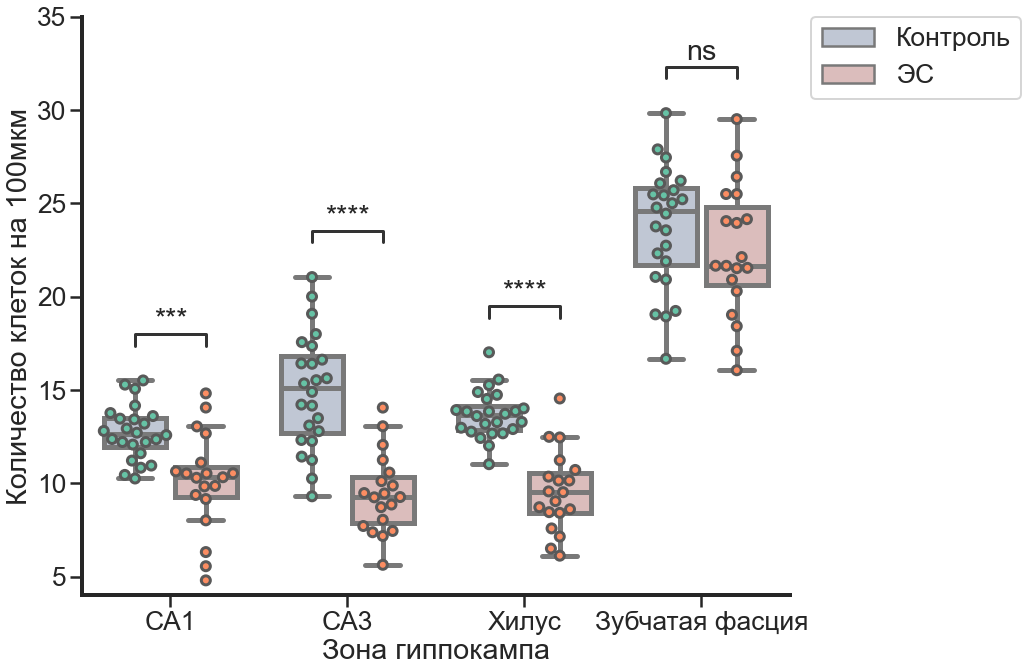

In [9]:
stat = boxplot_graph(all_cell_count, dots = True, fig_name = 'количество клеток',big_tick = 5, ylim = [4, 35])

Step 4. Export data to excel 

In [10]:
def stat_to_list(stat): 
    l = []
    for i in stat:
        l.append(str(i).split(','))
    for i in range(len(l)):
            l[i][1] = l[i].extend(l[i][1].split())
            l[i][1]= l[i].extend(l[i][2].split('='))
            l[i][1]= l[i].extend(l[i][3].split('='))
            del l[i][1]
            del l[i][1]
            del l[i][1]
    return l

We save the obtained values of statistical criteria into a dictionary due to the function stat_to_list()

In [11]:
stat_list = stat_to_list(stat)

We create a separate dataframe for easy export to excel

In [12]:
df_stat_out = pd.DataFrame(stat_list, columns = ['Test', 'feature', 'P-Val', 'feature2','U-stat'] ,index=['CA1', 'CA3', 'Hilus', 'DG'])
df_stat_out.drop(['feature','feature2'], axis= 'columns', inplace= True)

In [13]:
perc_cell_count_CTRL = cell_count_CTRL.quantile([0.25, 0.50 , 0.75])
perc_cell_count_SE = cell_count_SE.quantile([0.25, 0.50 , 0.75])
perc_cell_count_CTRL ['Group'] = 'Контроль'
perc_cell_count_SE ['Group'] = 'ЭС'
print(perc_cell_count_CTRL)
print()
print(perc_cell_count_SE)
perc_out = pd.concat([perc_cell_count_CTRL, perc_cell_count_SE])

            CA1        CA3      Hilus         DG     Group
0.25  11.956527  12.672735  12.868913  21.680620  Контроль
0.50  12.644153  15.123257  13.660260  24.607540  Контроль
0.75  13.496155  16.804472  14.137864  25.789426  Контроль

            CA1        CA3      Hilus        DG Group
0.25   9.265700   7.878748   8.434355  20.59655    ЭС
0.50  10.323550   9.263081   9.523810  21.65106    ЭС
0.75  10.874705  10.344400  10.535321  24.81800    ЭС


In [14]:
with pd.ExcelWriter('output_table/final_out_cell_count.xlsx') as writer:  
    perc_out.to_excel(writer, sheet_name='Precentile', float_format="%.2f")
    df_stat_out.to_excel(writer, sheet_name='P-val, MW(U)', float_format="%.3f")

Profit!